### NYU

In [1]:
root = '/home/wuyiming/git/Hand'
caffe_root = root + '/caffe'
import sys
sys.path.insert(0, caffe_root + '/python')
sys.path.insert(0, 'lib')
sys.path.insert(0, 'lib/data_layer/')
sys.path.insert(0, 'lib/data/')
sys.path.insert(0, 'lib/util/')

import caffe

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
from matplotlib.patches import Circle
import scipy.io as scio
import os
import time

In [2]:
fx = 588.03
fy = 587.07
ux = 320
uy = 240
def jointsImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((sample.shape[0], 3), np.float32)
    for i in range(sample.shape[0]):
        ret[i] = jointImgTo3D(sample[i])
    return ret

def jointImgTo3D(sample):
    """
    Normalize sample to metric 3D
    :param sample: joints in (x,y,z) with x,y in image coordinates and z in mm
    :return: normalized joints in mm
    """
    ret = np.zeros((3,), np.float32)
    # convert to metric using f, see Thomson et al.
    ret[0] = (sample[0] - ux) * sample[2] / fx
    ret[1] = (uy - sample[1]) * sample[2] / fy
    ret[2] = sample[2]
    return ret

def loadPredFile(filepath):
    import os
    assert os.path.isfile(filepath), "{} is not exists or is not a file!".format(filepath)
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            lines[index] = map(float, line.split())
        joints = np.array(lines)
        n, d = joints.shape
        return joints.reshape(n, d/3, 3)
    
def getNumFrameWithinMaxDist(gt, joints, dist):
    return (np.nanmax(np.sqrt(np.square(gt - joints).sum(axis=2)), axis=1) <= dist).sum()

def plotAccuracy(gt, joints, thresh = 80, label='ours'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([getNumFrameWithinMaxDist(gt, joints, j)/ float(joints.shape[0]) * 100. for j in range(0, 80)], label=label)
    ax.grid(True)
    plt.xlabel('Distance threshold / mm')
    plt.ylabel('Fraction of frames within threshold / %')
    plt.xlim((0, 80))
    plt.ylim((0.0, 100.0))

def predict_joints(model_name, weights_num):
    """predict joints"""
    model_def = 'models/NYU/hand_' + model_name + '/hand_' + model_name + '.prototxt'
    model_weights = 'weights/NYU/hand_' + model_name + '/hand_' + model_name + '_iter_' + weights_num + '.caffemodel'

    print model_def
    print model_weights
    
    net = caffe.Net(model_def,
                   model_weights,
                   caffe.TEST)
    
    file_name = 'result/OURS/NYU/hand_' + model_name + '_' + weights_num + '.txt'

    import os
    if os.path.isfile(file_name):
        return file_name
    
    print file_name
    
    t_start = time.time()

    predicted_joints = np.array([None]* 8252)

    for i in xrange(np.int(np.ceil(8252./ net.blobs['inds'].data.shape[0]))):
        net.forward()
        print 'iter = ', i
        for j, ind in enumerate(net.blobs['inds'].data):
            row = j / 32
            col = j % 32
            if predicted_joints[int(ind) - 1] == None:
                if model_name == 'baseline':
                    if ind <= 2440: # test 1
                        predicted_joints[int(ind) - 1] = (net.blobs['joint_pred'].data[j].reshape(14, 3)  * \
                                                          300 / 2 + net.blobs['com'].data[j].reshape(1, 3)).copy()
                    else: # test 2
                        predicted_joints[int(ind) - 1] = (net.blobs['joint_pred'].data[j].reshape(14, 3) * \
                                                         300 * 0.87 / 2 + net.blobs['com'].data[j].reshape(1, 3)).copy()
                else:
                    predicted_joints[int(ind) - 1] = (net.blobs['pred_joint'].data[row][col].reshape(14, 3)  * \
                                                      net.blobs['config'].data[j][0]/2 + net.blobs['com'].data[j].reshape(1, 3)).copy()
    t_end = time.time()
    print 'time elapse {}'.format((t_end - t_start) / 8252)
    
    with open(file_name, 'w') as f:
        for i in xrange(predicted_joints.shape[0]):
            for item in predicted_joints[i].reshape(14*3):
                f.write("%s "% item)
            f.write("\n")
     
    return file_name

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

### train

In [ ]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = None
solver = caffe.AdamSolver('./solver_baseline.prototxt')

solver.net.forward()
solver.test_nets[0].forward()

In [ ]:
img = (solver.net.blobs['depth'].data[0].reshape(128,128))
plt.imshow(img)
(solver.net.blobs['joint'].data[0]).reshape(14,3)

### test

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
net = caffe.Net('models/NYU/hand_lstm_small_frame_size/hand_lstm_small_frame_size.prototxt',
                'weights/NYU/hand_lstm_small_frame_size/hand_lstm_small_frame_size_iter_10000.caffemodel',
                caffe.TEST)

size of dataset is test1: 2440 and test2: 5812
dataset: NYU phase: test
Outputs:  ['depth', 'joint', 'clip_markers', 'com', 'config', 'inds']


In [5]:
net.forward()

{'loss': array(0.08721762895584106, dtype=float32)}

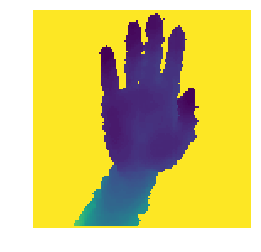

In [15]:
vis_square(net.blobs['depth'].data[0])

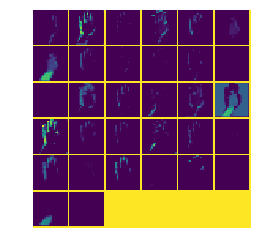

In [37]:
vis_square(net.blobs['pool2'].data[0])

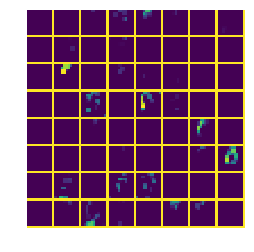

In [36]:
vis_square(net.blobs['pool3'].data[0])

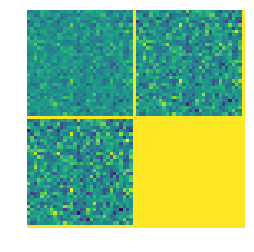

In [25]:
vis_square(net.blobs['lstm'].data.reshape(3, 32, 32))

In [15]:
net.blobs['pred_joint'].data.shape

(3, 1, 42)

## Plot the accuracy of hand pose estimation

### read the ground truth

In [5]:
gt_file = '/mnt/data/NYU-Hands-v2/test/joint_data.mat'
data = scio.loadmat(gt_file)
kinect_index = 0
image_index = 0
joint_uvd = data['joint_uvd'][kinect_index, :, :, :]
joint_xyz = data['joint_xyz'][kinect_index, :, :, :]
restrictedJoint = [0, 3, 6, 9, 12, 15, 18, 21, 24, 25, 27, 30, 31, 32]
joint_name = data['joint_names'].reshape(36, 1)

#### read the prediction(CVWW 2015)

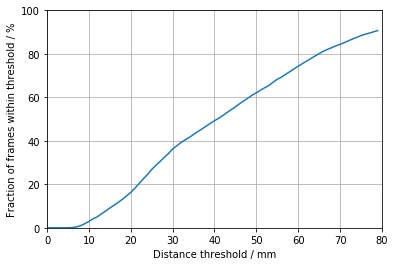

In [4]:
pred_file_CVWW15 = '../result/CVWW15/CVWW15_NYU_Prior.txt'
pred_joints = loadPredFile(pred_file_CVWW15)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

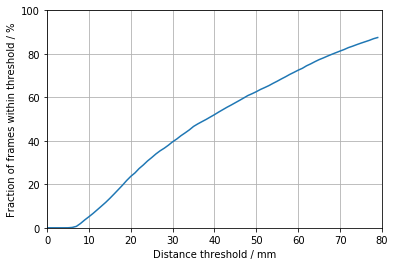

In [17]:
pred_file_CVWW15_refine = '../result/CVWW15/CVWW15_NYU_Prior-Refinement.txt'
pred_joints = loadPredFile(pred_file_CVWW15_refine)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

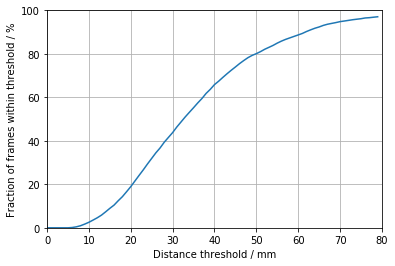

In [20]:
pred_file_ICCV = '../result/ICCV15/ICCV15_NYU_Feedback.txt'
pred_joints = loadPredFile(pred_file_ICCV)
pred_joints3D = []
for joints in pred_joints:
    joints3D = jointsImgTo3D(joints)
    pred_joints3D.append(joints3D)
pred_joints3D = np.asarray(pred_joints3D)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='ICCV')

#### predicted by ourselves

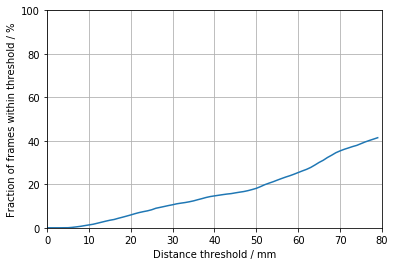

In [21]:
pred_ours_file = '../result/OURS/hand_lstm_160000.txt'
pred_joints3D = loadPredFile(pred_ours_file)

plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints3D, label='CVWW15')

models/NYU/hand_baseline/hand_baseline.prototxt
weights/NYU/hand_baseline/hand_baseline_iter_60000.caffemodel
result/OURS/NYU/hand_baseline_60000.txt
iter =  0
iter =  1
iter =  2
iter =  3
iter =  4
iter =  5
iter =  6
iter =  7
iter =  8
iter =  9
iter =  10
iter =  11
iter =  12
iter =  13
iter =  14
iter =  15
iter =  16
iter =  17
iter =  18
iter =  19
iter =  20
iter =  21
iter =  22
iter =  23
iter =  24
iter =  25
iter =  26
iter =  27
iter =  28
iter =  29
iter =  30
iter =  31
iter =  32
iter =  33
iter =  34
iter =  35
iter =  36
iter =  37
iter =  38
iter =  39
iter =  40
iter =  41
iter =  42
iter =  43
iter =  44
iter =  45
iter =  46
iter =  47
iter =  48
iter =  49
iter =  50
iter =  51
iter =  52
iter =  53
iter =  54
iter =  55
iter =  56
iter =  57
iter =  58
iter =  59
iter =  60
iter =  61
iter =  62
iter =  63
iter =  64
iter =  65
iter =  66
iter =  67
iter =  68
iter =  69
iter =  70
iter =  71
iter =  72
iter =  73
iter =  74
iter =  75
iter =  76
iter =  77
it

/home/wuyiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:83: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


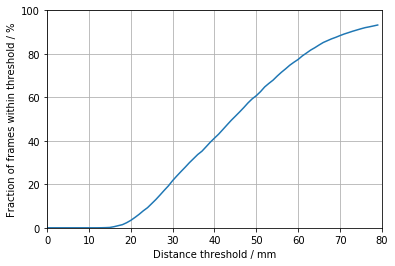

In [6]:
model_num = 'baseline'
weights_num = '60000'
pred_ours_file = predict_joints(model_num, weights_num)
pred_joints = loadPredFile(pred_ours_file)
plotAccuracy(joint_xyz[:, restrictedJoint], pred_joints, label='ours')